# Predict time 
## from minibatch size and GPU parameters
### Goal: predict one epoch time from batch size and platform parameters using Random Forest model

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess, os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
#!ls logs/microseries/DL

In [2]:
batch_learn_pattern = re.compile(r"^b\s*(\d+)\s+l\s*([0-9\.]+)")
output_pattern = re.compile(r"^(\d+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)")
remove_str="[J"


# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDF(logfile, debug=False):
    global batch_learn_pattern
    global output_pattern
    global remove_str
    logfile = logfile.strip(" \n")
    with open(logfile,"r") as f:
        lines = f.readlines()
        batch = 0
        time = 0
        epoch = 0
        ind = 0 # DataFrame row numebr (index)
        df = pd.DataFrame(data=None,columns=["batch","learn","epoch","time"])
        for line in lines:
            s = line.strip(' \n')
            s = s.replace(remove_str,"")
            m = batch_learn_pattern.match(s)
            if m:
                batch = int(m.group(1))
                learn = float(m.group(2))
            else:
                m2 = output_pattern.match(s)
                if m2:
                    epoch = int(m2.group(1))
                    time = float(m2.group(6))
                    if debug: print batch,learn,epoch,time
                    df.loc[ind] = [batch,learn,epoch,time]
                    ind += 1
                    
    return df

In [6]:
filename_pattern=re.compile(r"cifar_.*\.log")

def readLogs(logdir):
    global filename_pattern
    list_command = "ls -1 "+logdir
    files=[]
    proc = subprocess.Popen(list_command.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        line = line.strip(" \n")
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))
    df = pd.DataFrame(data=None,columns=["batch","learn","epoch","time"])

    for file in files:
        df1 = fileToDF(file)
        if len(df1) > 0:
            df = pd.concat([df,df1],ignore_index=True)
    return df

In [7]:
df_mouse=readLogs("logs/microseries/mouse")
df_DLsrv=readLogs("logs/microseries/DL")
df_mouse.head()

,batch,learn,epoch,time
0,101.0,0.15,1.0,90.3823
1,101.0,0.15,1.0,90.4984
2,102.0,0.15,1.0,90.1218
3,103.0,0.15,1.0,90.1364
4,104.0,0.15,1.0,90.1099


In [91]:
print df_DLsrv.shape
print df_mouse.shape

(961, 5)
(800, 5)


In [10]:
df_DLsrv["SP"] = 6144 # Single precision peak GFLOPS for GTX TITAN X
df_mouse["SP"] = 3000
df_DLsrv["Mem"] = 12.288 # GB
df_mouse["Mem"] = 5
df_DLsrv["Mband"] = 336 # GB/s
df_mouse["Mband"] = 140
df_DLsrv.drop(["learn","epoch"],axis=1,inplace=True)
df_mouse.drop(["learn","epoch"],axis=1,inplace=True)

print df_DLsrv.shape
print df_mouse.shape

(961, 5)
(800, 5)


In [12]:
df_mouse.head()

,batch,time,SP,Mem,Mband
0,101.0,90.3823,3000,5,140
1,101.0,90.4984,3000,5,140
2,102.0,90.1218,3000,5,140
3,103.0,90.1364,3000,5,140
4,104.0,90.1099,3000,5,140


In [14]:
df_DLsrv.head()

,batch,time,SP,Mem,Mband
0,1000.0,24.4252,6144,12.288,336
1,1001.0,24.4108,6144,12.288,336
2,1002.0,24.4341,6144,12.288,336
3,1003.0,24.7236,6144,12.288,336
4,1004.0,25.0943,6144,12.288,336


In [15]:
df = pd.concat([df_DLsrv,df_mouse],ignore_index=True)
df.head()

,batch,time,SP,Mem,Mband
0,1000.0,24.4252,6144,12.288,336
1,1001.0,24.4108,6144,12.288,336
2,1002.0,24.4341,6144,12.288,336
3,1003.0,24.7236,6144,12.288,336
4,1004.0,25.0943,6144,12.288,336


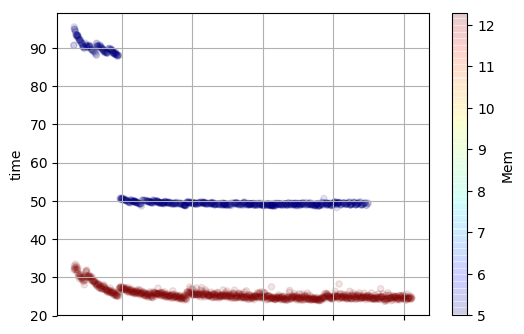

In [76]:
df.plot(kind="scatter",x="batch",y="time",c="Mem",grid=True,alpha=0.1,colormap="jet")

In [77]:
df[["batch","SP"]].head()

,batch,SP
0,1000.0,6144
1,1001.0,6144
2,1002.0,6144
3,1003.0,6144
4,1004.0,6144


In [111]:
X = df[["batch","SP","Mem","Mband"]].values
Y = df["time"].values

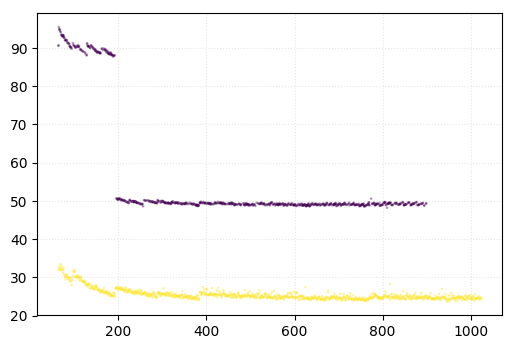

In [112]:
fig = plt.scatter(x=X[:,0],y=Y,c=X[:,1],s=1,alpha=0.3)
plt.grid(linestyle=":",alpha=0.3)
plt.show()

In [113]:
# Create training and test sets.
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.9, shuffle = True)

X_train[:3]

array([[  2.32000000e+02,   6.14400000e+03,   1.22880000e+01,
          3.36000000e+02],
       [  1.01000000e+02,   3.00000000e+03,   5.00000000e+00,
          1.40000000e+02],
       [  8.77000000e+02,   3.00000000e+03,   5.00000000e+00,
          1.40000000e+02]])

In [114]:
print X_train.shape

(176, 4)


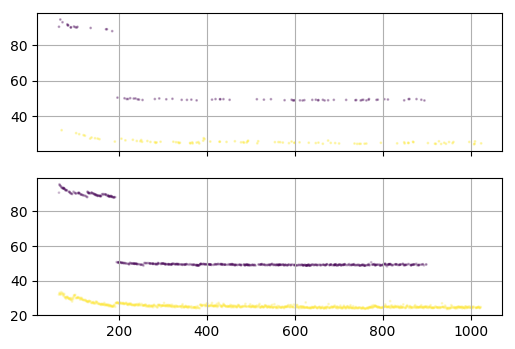

In [116]:
f, axarr = plt.subplots(2, sharex=True)
axarr[0].scatter(x=X_train[:,0],y=Y_train,c=X_train[:,2],s=1,alpha=0.3)
axarr[1].scatter(x=X_test[:,0],y=Y_test,c=X_test[:,2],s=1,alpha=0.2)
axarr[0].grid()
axarr[1].grid()
plt.show()

In [117]:
# Fit Random Forest
clf = RandomForestRegressor(n_estimators=50)
clf = clf.fit(X_train,Y_train)

In [118]:
H_test = clf.predict(X_test)

In [119]:
mean_squared_error(Y_test, H_test)

1.422162324994799

In [120]:
H_train = clf.predict(X_train)
mean_squared_error(Y_train, H_train)

0.90794538199506936

In [122]:
df[df["batch"] == 400]

,batch,time,SP,Mem,Mband
325,400.0,26.9757,6144,12.288,336
1247,400.0,49.2610,3000,5.000,140


In [123]:
clf.predict([[400.,3000,5,140]])

array([ 49.297374])

In [124]:
clf.predict([[400.,6144,12.288,336]])

array([ 26.94413])

In [125]:
clf.predict([[400.,6000,5,140]]) # Несуществующее устройство :)

array([ 40.354854])